In [5]:
import numpy as np
import pandas as pd
from copy import deepcopy
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define labe

In [6]:
# Define label mappings for binary classification (dry vs oily)
label_index = {"dry": 0, "oily": 1}
index_label = {0: "dry", 1: "oily"}

In [7]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        if i in label_index:  # Only include "dry" and "oily"
            label = os.path.join(base, i)
            for j in os.listdir(label):
                img = os.path.join(label, j)
                dd["images"].append(img)
                dd["labels"].append(label_index[i])
    return pd.DataFrame(dd)

In [8]:
train_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/train")
val_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/valid")
test_df = create_df("/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test")

# Combine all data, then split into train/validation/test sets
train_df, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val_df, test_df = train_test_split(testing, random_state=42, test_size=0.5)


In [9]:
class CloudDS(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img_path, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        
        return img, label

In [10]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Define transformations for validation and test sets
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [11]:
# Create Dataset and DataLoader instances
train_dataset = CloudDS(train_df, transform=train_transforms)
val_dataset = CloudDS(val_df, transform=val_test_transforms)
test_dataset = CloudDS(test_df, transform=val_test_transforms)

train_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [12]:
# Load pre-trained ResNet50 and adjust the final layer for 2 classes
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)  # Output for 2 classes: dry, oily

# Check if CUDA is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = deepcopy(resnet).to(device)

# Define loss, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s] 


In [13]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, 30):
    model.train()
    
    diff = 0
    total = 0
    acc = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
            
        out = model(data)
        
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        
        loss.backward()
        optimizer.step()
        
    train_loss.append(diff / total)
    train_acc.append(acc / total)
    
    # Validation step
    model.eval()
    
    diff = 0
    total = 0
    acc = 0
    
    with torch.no_grad():
        for data, target in val_dl:
            data, target = data.to(device), target.to(device)
                
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
            
    val_loss.append(diff / total)
    val_acc.append(acc / total)
    
    # Save the best model
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    # Step the learning rate scheduler
    scheduler.step()
    
    print(f"Epoch {epoch}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

Epoch 1, Train Loss: 0.0211, Train Acc: 0.6056, Val Loss: 0.0252, Val Acc: 0.5515
Epoch 2, Train Loss: 0.0202, Train Acc: 0.6533, Val Loss: 0.0236, Val Acc: 0.6424
Epoch 3, Train Loss: 0.0187, Train Acc: 0.6836, Val Loss: 0.0207, Val Acc: 0.6667
Epoch 4, Train Loss: 0.0179, Train Acc: 0.6964, Val Loss: 0.0202, Val Acc: 0.6788
Epoch 5, Train Loss: 0.0169, Train Acc: 0.7139, Val Loss: 0.0147, Val Acc: 0.8061
Epoch 6, Train Loss: 0.0157, Train Acc: 0.7540, Val Loss: 0.0149, Val Acc: 0.7939
Epoch 7, Train Loss: 0.0144, Train Acc: 0.7820, Val Loss: 0.0127, Val Acc: 0.8303
Epoch 8, Train Loss: 0.0141, Train Acc: 0.7812, Val Loss: 0.0137, Val Acc: 0.8242
Epoch 9, Train Loss: 0.0138, Train Acc: 0.7949, Val Loss: 0.0209, Val Acc: 0.7515
Epoch 10, Train Loss: 0.0121, Train Acc: 0.8198, Val Loss: 0.0187, Val Acc: 0.7758
Epoch 11, Train Loss: 0.0113, Train Acc: 0.8274, Val Loss: 0.0178, Val Acc: 0.8121
Epoch 12, Train Loss: 0.0110, Train Acc: 0.8410, Val Loss: 0.0089, Val Acc: 0.9030
Epoch 13, Tra

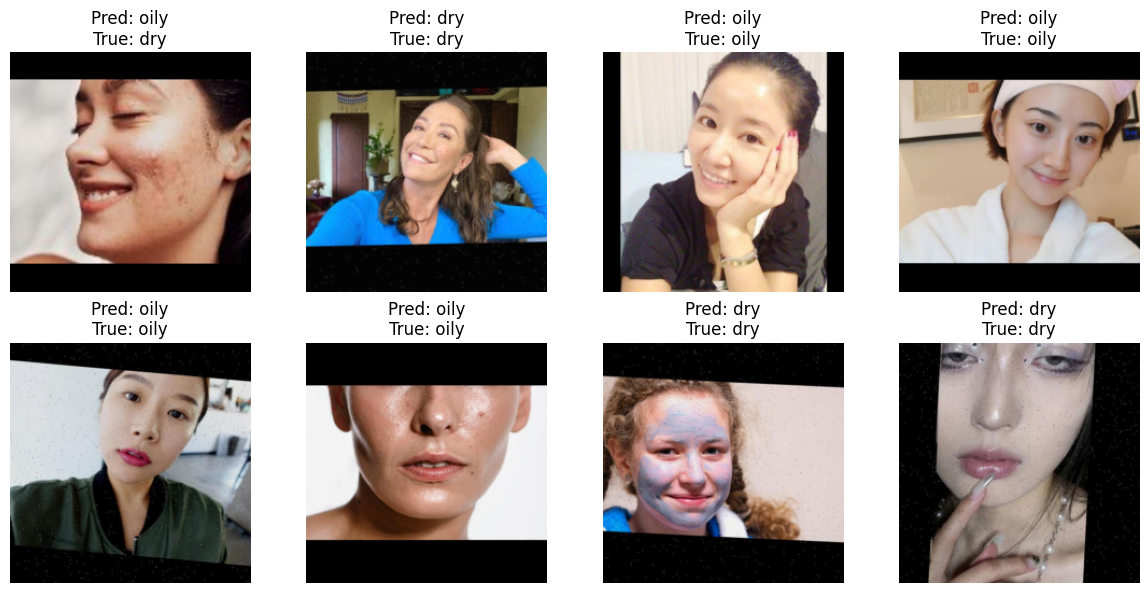

In [14]:
import matplotlib.pyplot as plt

model.eval()
label_map = {0: "dry", 1: "oily"}  # Updated for binary classification

# Recreate the DataLoader iterator
data_iter = iter(val_dl)
images, labels = next(data_iter)

# Move to device
images = images.to(device)
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(1)

# Move to CPU for plotting
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

plt.figure(figsize=(12, 6))
for idx in range(8):  # Show 8 images
    img = images[idx].permute(1, 2, 0)
    
    # Unnormalize (using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] from transforms)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)

    plt.subplot(2, 4, idx + 1)
    plt.imshow(img.numpy())
    plt.title(f"Pred: {label_map[preds[idx].item()]}\nTrue: {label_map[labels[idx].item()]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

Test Accuracy: 0.9578


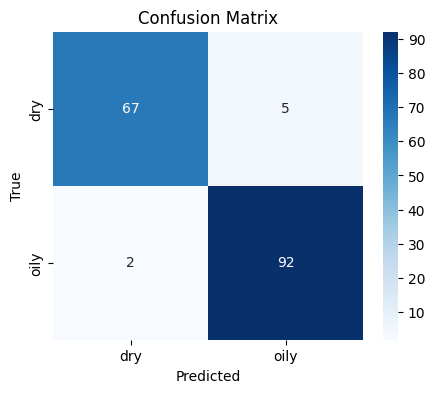

Classification Report:
               precision    recall  f1-score   support

         dry       0.97      0.93      0.95        72
        oily       0.95      0.98      0.96        94

    accuracy                           0.96       166
   macro avg       0.96      0.95      0.96       166
weighted avg       0.96      0.96      0.96       166



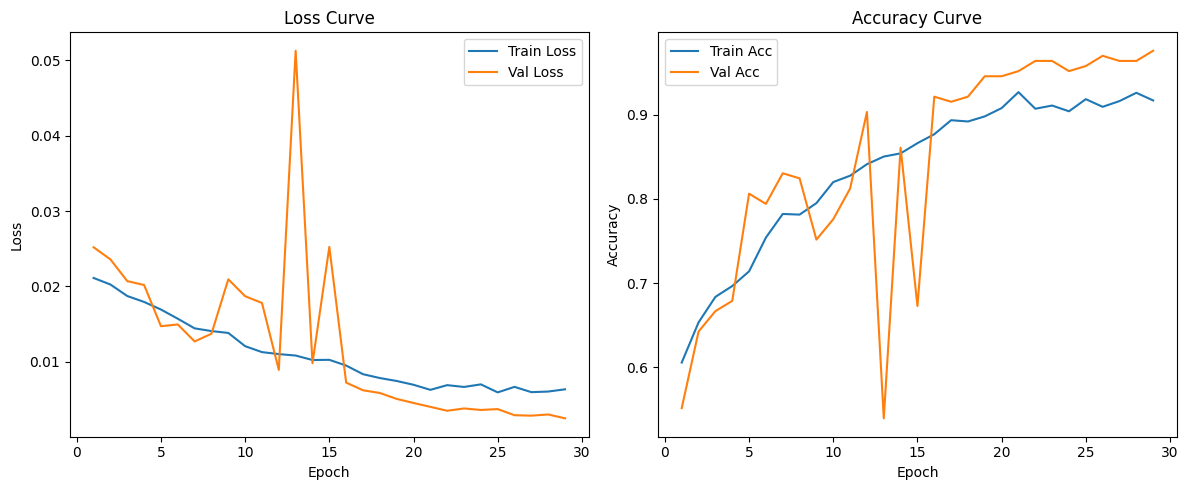

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Evaluate on Test Set ---
model.eval()
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

all_targets = []
all_preds = []

with torch.no_grad():
    for data, targets in test_dl:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        preds = outputs.argmax(1)
        all_targets.extend(targets.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# --- Accuracy ---
test_acc = accuracy_score(all_targets, all_preds)
print(f"Test Accuracy: {test_acc:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["dry", "oily"], yticklabels=["dry", "oily"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# --- Classification Report ---
cr = classification_report(all_targets, all_preds, target_names=["dry", "oily"])
print("Classification Report:\n", cr)

# --- Training/Validation Loss and Accuracy Curves ---
epochs = range(1, len(train_loss)+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
import torch
import pickle

# --- Saving the Model ---

# Save the best model's weights
torch.save(best_model.state_dict(), "best_skin_model.pth")


torch.save(best_model, "best_skin_model_entire.pth")

# Save training statistics
training_stats = {
    "train_loss": train_loss,
    "val_loss": val_loss,
    "train_acc": train_acc,
    "val_acc": val_acc,
}

with open("training_stats.pkl", "wb") as f:
    pickle.dump(training_stats, f)

# Save label mappings
with open("label_maps.pkl", "wb") as f:
    pickle.dump({"label_index": label_index, "index_label": index_label}, f)

print("Model and training artifacts saved successfully!")

Model and training artifacts saved successfully!


In [1]:
from PIL import Image
import torch

# ----------- Settings -----------
your_image_path = "/kaggle/input/oily-dry-and-normal-skin-types-dataset/Oily-Dry-Skin-Types/test/normal/normal_059b3e437854f2087e1c_jpg.rf.c222b7de169d732b9f68b9e0cc464308.jpg"  # <-- CHANGE THIS to your image path

# ----------- Load Model -----------
# (Assuming you’ve already run the reload code from previous cell)
# model, label_index, index_label already loaded and model in eval() mode

# ----------- Preprocess Single Image -----------
single_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = Image.open(your_image_path).convert("RGB")
input_tensor = single_transform(img).unsqueeze(0)  # Add batch dimension

# ----------- Prediction -----------
input_tensor = input_tensor.to(device)
with torch.no_grad():
    output = model(input_tensor)
    pred = output.argmax(1).item()

print(f"Predicted Skin Type: {index_label[pred]}")

NameError: name 'transforms' is not defined